# **Déscription des points décisionnels**
## **Pre-processing**
- Garder uniquement les sequences où SN_filter == 1 (remarque : ce n'est pas toutes les séquences qui ont les deux valeurs de réactivité, mais ça ne pose aucun problème).
- one-hot encoding pour les nucléotide et robust z-score normalization pour les réactivité.
- Appliquer la cross validation pour les données (ce n'est pas encore fait à cette version du 19 octobre. à l'état actuel : 0.8 pour train et 0.2 pour validation).
- Création d'un générateur de batch qui effectue le padding selon la séquence la plus longue au sein du batch.
- Créaction d'une custom loss qui effectue le masking aux NaN values des réactivités mais aussi le masking des valeurs paddées et calcule la MSE (sera utilisée pour entrainé le model. Autrement dit, la MAE et la RMSE seront calculées mais ne seront pas utilisé pour entraîner le model).
## **Model**
- Model de type LSTM
- Possède une couche de masking pour gérer les valeurs paddées au sein de chaque batch.
- Possède une couche d'entrée de largeur 4 (afin d'accépter les 4 colonnes du one-hot encoding des nucléotides) et de longueur None (afin d'accepter toutes la séquence quelle que soit sa taille).
- Possède une couche de sortie de largeur 2 (afin de retrouné deux valeurs de réactivité pour chaque nucléotide)

# **Load train data**

Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Load* train data

In [ ]:
import dask.dataframe as dd
import matplotlib.pyplot as plt

# Define the path of the CSV file
csv_path = '/content/drive/My Drive/M2BI_DRIVE/train_data.csv'

# Load the CSV file as a Dask DataFrame
train_data = dd.read_csv(csv_path)

# **Exploratory Data Analysis (EDA)**


To be completed: add analysis of shape of the data, pycharts, boxplots, pehaps PCA, univariate analysis, multivariate analysis...

In [ ]:
# Display the first 5 rows of the Dask DataFrame
train_data.head()

sequence_id                                           sequence  \
0  8cdfeef009ea  GGGAACGACUCGAGUAGAGUCGAAAAACGUUGAUAUGGAUUUACUC...   
1  51e61fbde94d  GGGAACGACUCGAGUAGAGUCGAAAAACAUUGAUAUGGAUUUACUC...   
2  25ce8d5109cd  GGGAACGACUCGAGUAGAGUCGAAAAACCUUGAUAUGGAUUUACUC...   
3  07dcfb6d1965  GGGAACGACUCGAGUAGAGUCGAAAAACUUUGAUAUGGAUUUACUC...   
4  e561cc042a4c  GGGAACGACUCGAGUAGAGUCGAAAAACGAUGAUAUGGAUUUACUC...   

  experiment_type dataset_name   reads  signal_to_noise  SN_filter  \
0         2A3_MaP      15k_2A3    2343            0.944          0   
1         2A3_MaP      15k_2A3    5326            1.933          1   
2         2A3_MaP      15k_2A3    4647            2.347          1   
3         2A3_MaP      15k_2A3  102843           11.824          1   
4         2A3_MaP      15k_2A3    7665            3.519          1   

   reactivity_0001  reactivity_0002  reactivity_0003  ...  \
0              NaN              NaN              NaN  ...   
1              NaN              NaN              NaN  ...   
2              NaN              NaN              NaN  ...   
3              NaN              NaN              NaN  ...   
4              NaN              NaN              NaN  ...   

   reactivity_error_0197  reactivity_error_0198  reactivity_error_0199  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   

   reactivity_error_0200  reactivity_error_0201  reactivity_error_0202  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   

   reactivity_error_0203  reactivity_error_0204  reactivity_error_0205  \
0                    NaN                    NaN                    NaN   
1                    NaN                    NaN                    NaN   
2                    NaN                    NaN                    NaN   
3                    NaN                    NaN                    NaN   
4                    NaN                    NaN                    NaN   

   reactivity_error_0206  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  

[5 rows x 419 columns]

Distribution of RNA sequences according to SN_filter

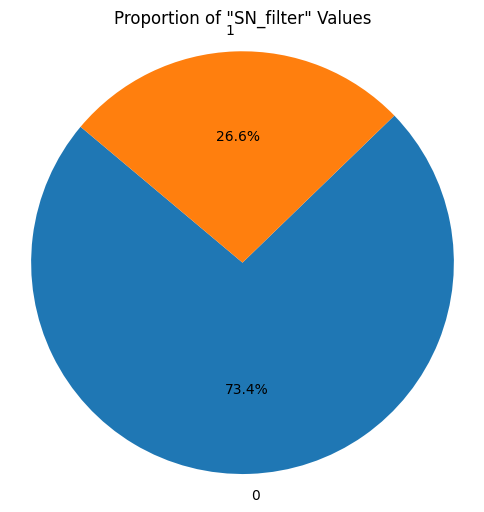

In [ ]:
# Compute the value counts for the "SN_filter" column
value_counts = train_data['SN_filter'].value_counts().compute()

# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of "SN_filter" Values')
plt.axis('equal')

# Show the pie chart
plt.show()

# **Feature engeneering**

Filter the rows where "SN_filter" is equal to 1



In [ ]:
# Create a copy of train_data
cleaned_train_data = train_data
# Filter the rows where "SN_filter" is equal to 1
cleaned_train_data = train_data[train_data['SN_filter'] == 1]
# Convert the Dask DataFrame to a Pandas DataFrame
cleaned_train_data = cleaned_train_data.compute()

Remove "sequence_id", "dataset_name", "reads", "SN_filter" and "reactivity_error" columns

In [ ]:
# List of columns to remove
columns_to_remove = ["sequence_id", "dataset_name", "reads", "SN_filter"]

# Find columns containing "reactivity_error" in their names
reactivity_error_columns = [col for col in cleaned_train_data.columns if "reactivity_error" in col]

# Combine the columns to remove
columns_to_remove.extend(reactivity_error_columns)

# Drop the specified columns from the DataFrame
cleaned_train_data = cleaned_train_data.drop(columns=columns_to_remove)

For each group of identical sequences, keep only the sequence with the highest signal to noise value

In [ ]:
import pandas as pd

# Create two separate DataFrames based on "experiment_type"
df_2A3_MaP = cleaned_train_data[cleaned_train_data['experiment_type'] == '2A3_MaP']
df_DMS_MaP = cleaned_train_data[cleaned_train_data['experiment_type'] == 'DMS_MaP']

# Delete cleaned_train_data to free space memory
del cleaned_train_data

# Function to keep rows with maximum signal_to_noise within identical sequences
def filter_identical_sequences(df):
    # Group by 'sequence' and keep the row with max 'signal_to_noise'
    filtered_df = df.groupby('sequence').apply(lambda x: x.loc[x['signal_to_noise'].idxmax()])
    return filtered_df

# Filter df_2A3_MaP
df_2A3_MaP = filter_identical_sequences(df_2A3_MaP)

# Filter df_DMS_MaP
df_DMS_MaP = filter_identical_sequences(df_DMS_MaP)

# Concatenate the two data frames
cleared_train_data = pd.concat([df_2A3_MaP, df_DMS_MaP], ignore_index=True)

# Delete df_2A3_MaP and df_DMS_MaP to free space memory
del df_2A3_MaP
del df_DMS_MaP

# Reset the index of the merged data frame
cleared_train_data.reset_index(drop=True, inplace=True)

# Remove the "signal_to_noise" column
cleared_train_data = cleared_train_data.drop(columns=['signal_to_noise'])

Reduce the size of the cleared_train_data. Code inspired from: https://www.kaggle.com/code/saikiranvarma/reduce-memory-of-training-data-by-50

In [ ]:
import numpy as np

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

#Reduce memory usage by assigning the real datatypes based on the data
cleared_train_data = reduce_mem_usage(cleared_train_data)

Mem. usage decreased to 325.10 Mb (50.1% reduction)


Save the cleared train data into a csv file

In [ ]:
# Save cleared_train_data as a CSV file
csv_path = '/content/drive/My Drive/M2BI_DRIVE/cleared_train_data.csv'
cleared_train_data.to_csv(csv_path, index=False)

Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load cleared_train_data

In [ ]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random

# Define the path of the CSV file
csv_path = '/content/drive/My Drive/M2BI_DRIVE/cleared_train_data.csv'

# Load the CSV file as a Dask DataFrame
cleared_train_data = pd.read_csv(csv_path)

# **Exploratory Data Analysis (EDA)**

RNA Sequence Length Distribution

RNA Sequence Length Distribution
   sequence_length  number_of_sequences
0              115                 2656
1              155                 2011
2              170                14577
3              177               221022
4              206                 2463


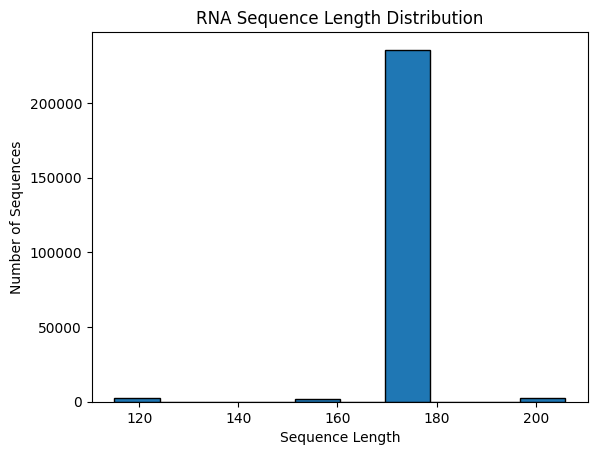

In [ ]:
# Create a DataFrame containing unique sequences
unique_sequences_df = cleared_train_data.drop_duplicates(subset='sequence')

# Calculate the length of each unique sequence and create a histogram
sequence_lengths = unique_sequences_df['sequence'].str.len()

# Plot summary table
table = sequence_lengths.value_counts().sort_index()

# Rename the columns
table = table.reset_index()
table.columns = ['sequence_length', 'number_of_sequences']

# Print or visualize the updated histogram
print("RNA Sequence Length Distribution")
print(table)

# Plot a histogram
# Define the bin width and the number of bins
bin_width = 10  # Adjust this value to change the bin width
num_bins = int((sequence_lengths.max() - sequence_lengths.min()) / bin_width) + 1

# Create the histogram
plt.hist(sequence_lengths, bins=num_bins, edgecolor='k')

# Customize the plot
plt.title("RNA Sequence Length Distribution")
plt.xlabel("Sequence Length")
plt.ylabel("Number of Sequences")

# Show the plot
plt.show()

Overall distribution of reactivity values across a random sample of RNA sequences according to the experiment type

In [ ]:
# Filter and create Dask DataFrames with more partitions
dms_map_df = dd.from_pandas(cleared_train_data[cleared_train_data['experiment_type'] == 'DMS_MaP'], npartitions=10)
twoa3_map_df = dd.from_pandas(cleared_train_data[cleared_train_data['experiment_type'] == '2A3_MaP'], npartitions=10)

# Function to create the violin plot using Plotly Express
def create_violin_plot(data, title):
    # Select the columns containing reactivity values
    reactivity_columns = [f'reactivity_{i:04d}' for i in range(1, 207)]

    # Randomly sample a portion of the data
    fraction_to_sample = 0.01
    sampled_data = data.sample(frac=fraction_to_sample, random_state=42)

    # Melt the Dask DataFrame to convert it into long format
    melted_data = sampled_data[reactivity_columns].melt()

    # Create a modern violin plot using Plotly Express
    fig = px.violin(melted_data.compute(), y="value", box=True, points="all", width=800, height=400,
                    title=f"{title}",
                    labels={"value": "Reactivity Value"})

    # Customize the plot appearance
    fig.update_traces(marker=dict(size=3, opacity=0.5), line_color='black')
    fig.update_xaxes(showticklabels=False)

    # Show the plot
    fig.show()

# Create the plot for "DMS_MaP" experiment_type
create_violin_plot(dms_map_df, "Distribution of Reactivity Values for DMS_MaP")

# Create the plot for "2A3_MaP" experiment_type
create_violin_plot(twoa3_map_df, "Distribution of Reactivity Values for 2A3_MaP")

# **Feature engineering**

Perform one-hot encoding for the nucleotides and for each nucleotide, combine with the two reactivity values normalized by robust z-score normalization (it was done in the cluster)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os

# Define a function to process the entire DataFrame
def process_dataframe(df):
    result_list = []
    unique_sequences = df['sequence'].unique()

    # Create empty lists to store values for robust normalization
    dms_values = []
    a3_values = []

    for sequence in unique_sequences:
        sequence_data = df[df['sequence'] == sequence]
        dms_map_row = sequence_data[sequence_data['experiment_type'] == 'DMS_MaP']
        a3_map_row = sequence_data[sequence_data['experiment_type'] == '2A3_MaP']

        tensor_rows = []
        for i in range(len(sequence)):
            dms_value = dms_map_row[f'reactivity_{i+1:04d}'].iloc[0] if not dms_map_row.empty else np.nan
            a3_value = a3_map_row[f'reactivity_{i+1:04d}'].iloc[0] if not a3_map_row.empty else np.nan
            nucleotide = sequence[i]
            tensor_row = [nucleotide, dms_value, a3_value]
            tensor_rows.append(tensor_row)

            # Append values for robust normalization, only if they are not NaN
            if not np.isnan(dms_value):
                dms_values.append(dms_value)
            if not np.isnan(a3_value):
                a3_values.append(a3_value)

        # Create a DataFrame from the tensor_rows
        tensor_df = pd.DataFrame(tensor_rows, columns=['Nucleotide', 'DMS_MaP_Reactivity', '2A3_MaP_Reactivity'])

        # Perform one-hot encoding for the 'Nucleotide' column
        nucleotide_encoded = pd.get_dummies(tensor_df['Nucleotide'], prefix='Nucleotide')

        # Drop the original 'Nucleotide' column
        tensor_df.drop(columns=['Nucleotide'], inplace=True)

        # Concatenate the one-hot encoded columns with the original DataFrame
        tensor_df = pd.concat([nucleotide_encoded, tensor_df], axis=1)

        result_list.append(tensor_df)

    # Calculate median and Median Absolute Deviation (MAD) for robust normalization
    dms_median = np.nanmedian(dms_values)
    a3_median = np.nanmedian(a3_values)
    dms_mad = np.nanmedian(np.abs(np.array(dms_values) - dms_median))
    a3_mad = np.nanmedian(np.abs(np.array(a3_values) - a3_median))

    # Print the calculated values
    print("dms_median:", dms_median)
    print("a3_median:", a3_median)
    print("dms_mad:", dms_mad)
    print("a3_mad:", a3_mad)

    # Apply robust z-score normalization to all DataFrames
    for i in range(len(result_list)):
        result_list[i]['DMS_MaP_Reactivity'] = (result_list[i]['DMS_MaP_Reactivity'] - dms_median) / (1.482602218505602 * dms_mad)
        result_list[i]['2A3_MaP_Reactivity'] = (result_list[i]['2A3_MaP_Reactivity'] - a3_median) / (1.482602218505602 * a3_mad)

    # Convert each data frame into a NumPy array
    array_list = [df.to_records(index=False) for df in result_list]

    return array_list

# Apply the function to the entire DataFrame
ohe_cleared_train_data = process_dataframe(cleared_train_data)

Save ohe_cleared_train_data

In [ ]:
# Define the output directory
NPY_path = '/content/drive/My Drive/M2BI_DRIVE/ohe_cleared_train_data.npy'
np.save(NPY_path, ohe_cleared_train_data)

# **Build model and tune hyperparameters**

Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load ohe_cleared_train_data

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats  # Import the stats module for z-score normalization

# Define the path of the CSV file
npy_path = '/content/drive/My Drive/M2BI_DRIVE/ohe_cleared_train_data.npy'

# Load the NPY file
ohe_cleared_train_data = np.load(npy_path, allow_pickle=True)

Subset the data

In [ ]:
sub_ohe_cleared_train_data = ohe_cleared_train_data[0:500]
#import random

# Randomly subset 1% of RNA sequence
#num_arrays = len(ohe_cleared_train_data)
#num_to_select = int(num_arrays * (1 / 100))
#random_indices = random.sample(range(num_arrays), num_to_select)
#sub_ohe_cleared_train_data = [ohe_cleared_train_data[i] for i in random_indices]
#print("Hyperparameters will be tuned using ", len(sub_ohe_cleared_train_data), " RNA sequence")

In [ ]:
# Install optuna and kaleido package
!pip install optuna-integration
!pip install -U kaleido

In [ ]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Masking, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.utils import plot_model
from contextlib import redirect_stdout
import optuna.visualization as vis
import matplotlib.pyplot as plt
from tensorflow import keras
import plotly.io as pio
from PIL import Image
import io

# Define batch size
batch_size = 32

# Split the data into train_data and val_data
split_ratio = 0.8
split_index = int(len(sub_ohe_cleared_train_data) * split_ratio)
X_train = [seq[['Nucleotide_A', 'Nucleotide_C', 'Nucleotide_G', 'Nucleotide_U']].tolist() for seq in sub_ohe_cleared_train_data[:split_index]]
y_train = [seq[['DMS_MaP_Reactivity', '2A3_MaP_Reactivity']].tolist() for seq in sub_ohe_cleared_train_data[:split_index]]
X_val = [seq[['Nucleotide_A', 'Nucleotide_C', 'Nucleotide_G', 'Nucleotide_U']].tolist() for seq in sub_ohe_cleared_train_data[split_index:]]
y_val = [seq[['DMS_MaP_Reactivity', '2A3_MaP_Reactivity']].tolist() for seq in sub_ohe_cleared_train_data[split_index:]]

# Create a generator function to yield batches of data with RNA sequence padding
def data_generator(X, y, batch_size):
    num_samples = len(X)
    while True:
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            X_batch = X[start:end]
            y_batch = y[start:end]

            # Pad RNA sequences to the length of the longest sequence within the batch
            max_length = max(len(seq) for seq in X_batch)
            X_batch = pad_sequences(X_batch, padding='post', dtype='float32', maxlen=max_length)
            y_batch = pad_sequences(y_batch, padding='post', dtype='float32', maxlen=max_length)

            yield X_batch, y_batch

# Define a custom loss function
def custom_loss(y_true, y_pred, padded_value=0.0):
    nan_mask = tf.math.is_nan(y_true)
    padded_mask = tf.math.equal(y_true, padded_value)

    # Create a composite mask that identifies both NaN and padded values
    composite_mask = tf.math.logical_or(nan_mask, padded_mask)

    # Replace NaN and padded values with 0.0
    modified_true = tf.where(composite_mask, 0.0, y_true)

    # Calculate the mean squared difference (MSE)
    loss = tf.reduce_mean(tf.square(modified_true - y_pred))

    return loss

# Define a function to build the LSTM model with hyperparameters
def build_lstm_model(input_shape, lstm_layers, lstm_units, dense_units, dropout_rates, use_batch_normalization_layers, use_dropout_layers, use_dense_layers, output_dim=2):
    model = Sequential()
    model.add(Masking(mask_value=0.0, input_shape=input_shape))

    for i, (layer_type, units) in enumerate(zip(lstm_layers, lstm_units)):
        if layer_type == 'LSTM':
            layer = LSTM(units, return_sequences=True)
        elif layer_type == 'Bidirectional':
            layer = Bidirectional(LSTM(units, return_sequences=True))
        model.add(layer)

        if i in use_batch_normalization_layers:
            model.add(BatchNormalization())

        if use_dropout_layers[i]:
            model.add(Dropout(dropout_rates[i]))

    for units in dense_units:
        model.add(Dense(units, activation='relu'))

    model.add(Dense(output_dim, activation='linear'))
    model.compile(optimizer='adam', loss=custom_loss)
    return model

# Define the optimization objective
def objective(trial):
    # Hyperparameter search space
    lstm_units = []
    dropout_rates = []
    dense_units = []

    num_lstm_layers = trial.suggest_int("num_lstm_layers", 1, 5)
    lstm_layers = [trial.suggest_categorical(f"lstm_layer_{i}", ["LSTM", "Bidirectional"]) for i in range(num_lstm_layers)]

    for i in range(num_lstm_layers):
        max_units = 256 if i == 0 else lstm_units[i - 1]
        units_lstm = trial.suggest_int(f"lstm_units_{i}", 32, max_units)
        lstm_units.append(units_lstm)
    use_dropout_layers = [trial.suggest_categorical(f"use_dropout_{i}", [True, False]) for i in range(num_lstm_layers)]
    dropout_rates = [trial.suggest_float(f"dropout_rate_{i}", 0.0, 0.5) for i in range(num_lstm_layers)]
    use_batch_normalization_layers = [trial.suggest_categorical(f"use_batch_normalization_{i}", [True, False]) for i in range(num_lstm_layers)]

    use_dense_layers = trial.suggest_int("use_dense_layers", 0, 3)

    for i in range(use_dense_layers):
        max_units = lstm_units[-1] if i == 0 else dense_units[i - 1]
        units_dense = trial.suggest_int(f"dense_units_{i}", 16, max_units)
        dense_units.append(units_dense)

    # Build the model with the suggested hyperparameters
    model = build_lstm_model((None, 4), lstm_layers, lstm_units, dense_units, dropout_rates, use_batch_normalization_layers, use_dropout_layers, use_dense_layers)

    # Train the model and return the validation loss for optimization
    num_epochs = 10
    train_steps = len(X_train) // batch_size
    val_steps = len(X_val) // batch_size
    train_losses = []
    val_losses = []

    train_data_generator = data_generator(X_train, y_train, batch_size)
    val_data_generator = data_generator(X_val, y_val, batch_size)

    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0

        with open('/dev/null', 'w') as null_file:
            with redirect_stdout(null_file):
                for _ in range(train_steps):
                    X_batch, y_batch = next(train_data_generator)
                    batch_loss = model.train_on_batch(X_batch, y_batch)
                    train_loss += batch_loss

                for _ in range(val_steps):
                    X_batch, y_batch = next(val_data_generator)
                    batch_loss = model.test_on_batch(X_batch, y_batch)
                    val_loss += batch_loss

        train_losses.append(train_loss / train_steps)
        val_losses.append(val_loss / val_steps)

    # Inside the objective function, get the trial number from the `trial` object
    trial_number = trial.number

    # Save the entire model to a file, including architecture, optimizer, and weights
    model.save(f'/content/drive/My Drive/M2BI_DRIVE/model_trial_{trial_number}.h5')

    # Assuming you already have a 'study' object from your optimization
    fig = vis.plot_optimization_history(study)

    # Save the Plotly figure as a PNG image
    png_image_bytes = pio.to_image(fig, format="png")

    # Convert the PNG image to PIL Image and convert it to RGB format
    png_image = Image.open(io.BytesIO(png_image_bytes)).convert("RGB")

    # Save the PIL Image as a PDF
    pdf_file = f'/content/drive/My Drive/M2BI_DRIVE/values_vs_trials_trial_{trial_number}.pdf'
    png_image.save(pdf_file, "PDF")

    # Report the validation loss for Optuna to minimize
    return val_loss / val_steps

# Create an Optuna study for hyperparameter optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=3)  # Change the number of trials as needed
best_params = study.best_params

# Build the final model with the best hyperparameters
best_num_lstm_layers = best_params['num_lstm_layers']
best_lstm_units = [best_params[f'lstm_units_{i}'] for i in range(best_num_lstm_layers)]
best_use_dropout_layers = []
for i in range(best_num_lstm_layers):
    use_dropout_i = best_params[f"use_dropout_{i}"]
    best_use_dropout_layers.append(use_dropout_i)
best_dropout_rates = []
for i in range(best_num_lstm_layers):
    if best_use_dropout_layers[i]:
        best_dropout_rates.append(best_params[f"dropout_rate_{i}"])
    else:
        best_dropout_rates.append(0.0)
best_lstm_layers = [best_params[f'lstm_layer_{i}'] for i in range(best_num_lstm_layers)]
best_use_batch_normalization_layers = [best_params[f'use_batch_normalization_{i}'] for i in range(best_num_lstm_layers)]
best_use_dense_layers = best_params['use_dense_layers']
best_dense_units = []
for i in range(best_use_dense_layers):
    key = f"dense_units_{i}"
    best_dense_units.append(best_params[key])
best_model = build_lstm_model((None, 4), best_lstm_layers, best_lstm_units, best_dense_units, best_dropout_rates, best_use_batch_normalization_layers, best_use_dropout_layers, best_use_dense_layers)

# Save the entire model to a file, including architecture, optimizer, and weights
best_model.save('/content/drive/My Drive/M2BI_DRIVE/best_model.h5')

[I 2023-10-22 15:10:17,800] A new study created in memory with name: no-name-9384d7f7-6750-46b7-84c4-b183696d1de8
[W 2023-10-22 15:11:20,590] There are no complete trials.
[I 2023-10-22 15:11:20,700] Trial 0 finished with value: 8.10634740193685 and parameters: {'num_lstm_layers': 2, 'lstm_layer_0': 'LSTM', 'lstm_layer_1': 'LSTM', 'lstm_units_0': 64, 'lstm_units_1': 48, 'use_dropout_0': False, 'use_dropout_1': False, 'dropout_rate_0': 0.004244691947469237, 'dropout_rate_1': 0.3870125879920491, 'use_batch_normalization_0': False, 'use_batch_normalization_1': False, 'use_dense_layers': 3, 'dense_units_0': 31, 'dense_units_1': 28, 'dense_units_2': 23}. Best is trial 0 with value: 8.10634740193685.
[I 2023-10-22 15:15:02,766] Trial 1 finished with value: 8.144810199737549 and parameters: {'num_lstm_layers': 2, 'lstm_layer_0': 'LSTM', 'lstm_layer_1': 'Bidirectional', 'lstm_units_0': 141, 'lstm_units_1': 123, 'use_dropout_0': True, 'use_dropout_1': True, 'dropout_rate_0': 0.3474942341620285,

In [ ]:
# Visualize optimization history
vis.plot_optimization_history(study)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_7 (Masking)         (None, None, 4)           0         
                                                                 
 lstm_14 (LSTM)              (None, None, 64)          17664     
                                                                 
 batch_normalization_6 (Bat  (None, None, 64)          256       
 chNormalization)                                                
                                                                 
 lstm_15 (LSTM)              (None, None, 48)          21696     
                                                                 
 dense_25 (Dense)            (None, None, 31)          1519      
                                                                 
 dense_26 (Dense)            (None, None, 28)          896       
                                                      

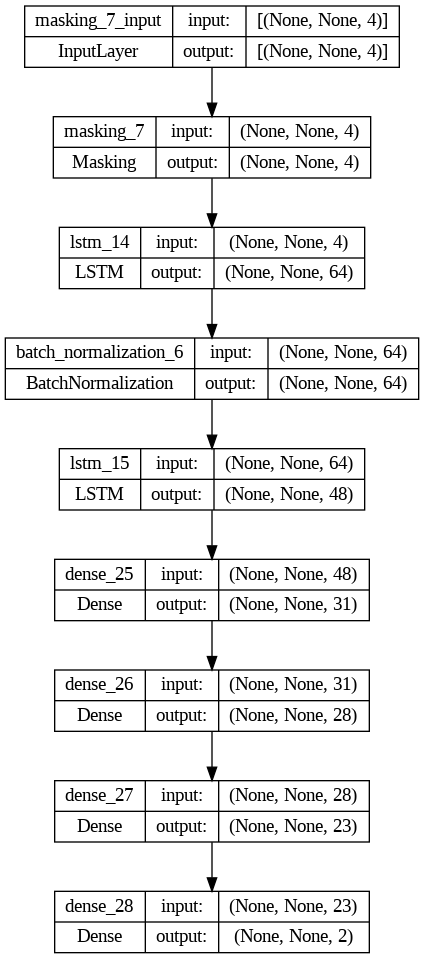

In [ ]:
# Display model's structure model and  summary
best_model.summary()
plot_model(best_model, show_shapes=True, show_layer_names=True)

# **Train the best model**

Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load ohe_cleared_train_data

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats  # Import the stats module for z-score normalization

# Define the path of the CSV file
npy_path = '/content/drive/My Drive/M2BI_DRIVE/ohe_cleared_train_data.npy'

# Load the NPY file
ohe_cleared_train_data = np.load(npy_path, allow_pickle=True)

In [ ]:
ohe_cleared_train_data = ohe_cleared_train_data[0:1000]

Load the model ans see its caracteristics

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.models import load_model

# Define custom loss which is a custom object
def custom_loss(y_true, y_pred, padded_value=0.0):
    nan_mask = tf.math.is_nan(y_true)
    padded_mask = tf.math.equal(y_true, padded_value)

    # Create a composite mask that identifies both NaN and padded values
    composite_mask = tf.math.logical_or(nan_mask, padded_mask)

    # Replace NaN and padded values with 0.0
    modified_true = tf.where(composite_mask, 0.0, y_true)

    # Calculate the mean squared difference (MSE)
    loss = tf.reduce_mean(tf.square(modified_true - y_pred))

    return loss

# Define a dictionary of custom objects to be used during model loading
custom_objects = {'custom_loss': custom_loss}
# Load the model
model = load_model('/content/drive/My Drive/M2BI_DRIVE/model_trial_20.h5', custom_objects=custom_objects)

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_20 (Masking)        (None, None, 4)           0         
                                                                 
 bidirectional_35 (Bidirect  (None, None, 452)         417648    
 ional)                                                          
                                                                 
 batch_normalization_26 (Ba  (None, None, 452)         1808      
 tchNormalization)                                               
                                                                 
 bidirectional_36 (Bidirect  (None, None, 388)         1004144   
 ional)                                                          
                                                                 
 batch_normalization_27 (Ba  (None, None, 388)         1552      
 tchNormalization)                                   

Train the model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
import sys
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from math import inf
import os
import random
import pickle

# Define batch size
batch_size = 64

# Shuffle the data
random.shuffle(ohe_cleared_train_data)

# Split ratios
train_ratio = 0.6  # 60% for training
val_ratio = 0.2    # 20% for validation
test_ratio = 0.2   # 20% for testing

# Calculate the split indices
total_samples = len(ohe_cleared_train_data)
train_split_index = int(total_samples * train_ratio)
val_split_index = int(total_samples * (train_ratio + val_ratio))

# Split the data into train_data, val_data, and test_data
X_train = [seq[['Nucleotide_A', 'Nucleotide_C', 'Nucleotide_G', 'Nucleotide_U']].tolist() for seq in ohe_cleared_train_data[:train_split_index]]
y_train = [seq[['DMS_MaP_Reactivity', '2A3_MaP_Reactivity']].tolist() for seq in ohe_cleared_train_data[:train_split_index]]
X_val = [seq[['Nucleotide_A', 'Nucleotide_C', 'Nucleotide_G', 'Nucleotide_U']].tolist() for seq in ohe_cleared_train_data[train_split_index:val_split_index]]
y_val = [seq[['DMS_MaP_Reactivity', '2A3_MaP_Reactivity']].tolist() for seq in ohe_cleared_train_data[train_split_index:val_split_index]]
X_test = [seq[['Nucleotide_A', 'Nucleotide_C', 'Nucleotide_G', 'Nucleotide_U']].tolist() for seq in ohe_cleared_train_data[val_split_index:]]
y_test = [seq[['DMS_MaP_Reactivity', '2A3_MaP_Reactivity']].tolist() for seq in ohe_cleared_train_data[val_split_index:]]

# Save X_test to a file
#np.save('/content/drive/My Drive/M2BI_DRIVE/X_test.npy', X_test)
with open('/content/drive/My Drive/M2BI_DRIVE/X_test.pkl', 'wb') as file:
    pickle.dump(X_test, file)
# Save y_test to a file
#np.save('/content/drive/My Drive/M2BI_DRIVE/y_test.npy', y_test)
with open('/content/drive/My Drive/M2BI_DRIVE/y_test.pkl', 'wb') as file:
    pickle.dump(y_test, file)

# Create a generator function to yield batches of data with RNA sequence padding
def data_generator(X, y, batch_size):
    num_samples = len(X)
    while True:
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            X_batch = X[start:end]
            y_batch = y[start:end]

            # Pad RNA sequences to the length of the longest sequence within the batch
            max_length = max(len(seq) for seq in X_batch)
            X_batch = pad_sequences(X_batch, padding='post', dtype='float32', maxlen=max_length)
            y_batch = pad_sequences(y_batch, padding='post', dtype='float32', maxlen=max_length)

            yield X_batch, y_batch

def custom_loss(y_true, y_pred, padded_value=0.0):
    nan_mask = tf.math.is_nan(y_true)
    padded_mask = tf.math.equal(y_true, padded_value)

    # Create a composite mask that identifies both NaN and padded values
    composite_mask = tf.math.logical_or(nan_mask, padded_mask)

    # Replace NaN and padded values with 0.0
    modified_true = tf.where(composite_mask, 0.0, y_true)

    # Calculate the mean squared difference (MSE)
    loss = tf.reduce_mean(tf.square(modified_true - y_pred))

    return loss

# Fit the model using the generator
train_steps = len(X_train) // batch_size
val_steps = len(X_val) // batch_size

# Create lists to store loss, MAE, and RMSE values for training and validation
train_losses = []
val_losses = []
train_maes = []
val_maes = []
train_rmses = []
val_rmses = []

train_data_generator = data_generator(X_train, y_train, batch_size)
val_data_generator = data_generator(X_val, y_val, batch_size)

num_epochs = 10000
# Define early stopping parameters
min_delta = 0  # Minimum change in validation loss to be considered an improvement
patience = 30   # Number of epochs with no improvement before stopping
best_val_loss = float('inf')  # Initialize the best validation loss
wait = 0  # Counter for patience

# Model's epoch number
model_epoch = 0

# Initialize the best validation loss and best epoch
best_val_loss = float('inf')
best_epoch = 0

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_mae = 0.0
    val_mae = 0.0
    train_rmse = 0.0
    val_rmse = 0.0

    # Redirect stdout to /dev/null
    with open('/dev/null', 'w') as null_file:
        with redirect_stdout(null_file):
            for _ in range(train_steps):
                X_batch, y_batch = next(train_data_generator)
                batch_loss = model.train_on_batch(X_batch, y_batch)

                # Calculate MAE and RMSE separately
                batch_mae = MeanAbsoluteError()(y_batch, model.predict(X_batch))
                batch_rmse = RootMeanSquaredError()(y_batch, model.predict(X_batch))

                # Apply the same masking as in the custom loss function
                nan_mask = tf.math.is_nan(y_batch)
                padded_mask = tf.math.equal(y_batch, 0.0)
                composite_mask = tf.math.logical_or(nan_mask, padded_mask)
                modified_y_batch = tf.where(composite_mask, 0.0, y_batch)

                train_loss += batch_loss
                train_mae += tf.reduce_mean(tf.abs(modified_y_batch - model.predict(X_batch)))
                train_rmse += tf.sqrt(tf.reduce_mean(tf.square(modified_y_batch - model.predict(X_batch))))

            for _ in range(val_steps):
                X_batch, y_batch = next(val_data_generator)
                batch_loss = model.test_on_batch(X_batch, y_batch)

                # Calculate MAE and RMSE separately
                batch_mae = MeanAbsoluteError()(y_batch, model.predict(X_batch))
                batch_rmse = RootMeanSquaredError()(y_batch, model.predict(X_batch))

                # Apply the same masking as in the custom loss function
                nan_mask = tf.math.is_nan(y_batch)
                padded_mask = tf.math.equal(y_batch, 0.0)
                composite_mask = tf.math.logical_or(nan_mask, padded_mask)
                modified_y_batch = tf.where(composite_mask, 0.0, y_batch)

                val_loss += batch_loss
                val_mae += tf.reduce_mean(tf.abs(modified_y_batch - model.predict(X_batch)))
                val_rmse += tf.sqrt(tf.reduce_mean(tf.square(modified_y_batch - model.predict(X_batch))))

    train_losses.append(train_loss / train_steps)
    val_losses.append(val_loss / val_steps)

    train_maes.append(train_mae / train_steps)
    val_maes.append(val_mae / val_steps)
    train_rmses.append(train_rmse / train_steps)
    val_rmses.append(val_rmse / val_steps)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1  # Note that epochs are 0-indexed

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss / train_steps}, Validation Loss: {val_loss / val_steps}, Train MAE: {train_mae / train_steps}, Validation MAE: {val_mae / val_steps}, Train RMSE: {train_rmse / train_steps}, Validation RMSE: {val_rmse / val_steps}, Best Epoch: {best_epoch}")

    # Save the model at the end of each epoch
    model_epoch += 1
    model.save(f'/content/drive/My Drive/M2BI_DRIVE/trained_model_{model_epoch}_val_loss_{val_loss / val_steps}_.h5')

    # Save metrics to a file
    metrics_filename = f"/content/drive/My Drive/M2BI_DRIVE/training_metrics/metrics_epoch_{epoch + 1}.txt"
    with open(metrics_filename, 'w') as metrics_file:
        metrics_file.write(f"Train Loss: {train_loss / train_steps}\n")
        metrics_file.write(f"Validation Loss: {val_loss / val_steps}\n")
        metrics_file.write(f"Train MAE: {train_mae / train_steps}\n")
        metrics_file.write(f"Validation MAE: {val_mae / val_steps}\n")
        metrics_file.write(f"Train RMSE: {train_rmse / train_steps}\n")
        metrics_file.write(f"Validation RMSE: {val_rmse / val_steps}\n")

    # Check for early stopping
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        wait = 0  # Reset the patience counter
    else:
        wait += 1  # Increment the patience counter

    if wait >= patience:
        print("Early stopping triggered.")
        break

Epoch 1/10000, Train Loss: 3.071975072224935, Validation Loss: 3.0546120007832847, Train MAE: 0.6844587922096252, Validation MAE: 0.6896524429321289, Train RMSE: 1.7036057710647583, Validation RMSE: 1.7449445724487305, Best Epoch: 1


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10000, Train Loss: 2.5173804230160184, Validation Loss: 3.1602012316385903, Train MAE: 0.676604151725769, Validation MAE: 0.7239710688591003, Train RMSE: 1.6529916524887085, Validation RMSE: 1.7761980295181274, Best Epoch: 1
Epoch 3/10000, Train Loss: 2.1456140412224665, Validation Loss: 2.7851529121398926, Train MAE: 0.64351487159729, Validation MAE: 0.6857531666755676, Train RMSE: 1.5418376922607422, Validation RMSE: 1.6685036420822144, Best Epoch: 3
Epoch 4/10000, Train Loss: 1.8451527622010973, Validation Loss: 2.903197924296061, Train MAE: 0.6119086742401123, Validation MAE: 0.673475980758667, Train RMSE: 1.436385989189148, Validation RMSE: 1.701574683189392, Best Epoch: 3
Epoch 5/10000, Train Loss: 1.5859639644622803, Validation Loss: 2.932218551635742, Train MAE: 0.5864995121955872, Validation MAE: 0.6553574800491333, Train RMSE: 1.3472137451171875, Validation RMSE: 1.710609793663025, Best Epoch: 3
Epoch 6/10000, Train Loss: 1.369864583015442, Validation Loss: 2.99988134

KeyboardInterrupt: ignored

# **Check the efficiency of the model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load metrics

In [ ]:
import os
import matplotlib.pyplot as plt
from keras.models import load_model
from contextlib import redirect_stdout
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import numpy as np
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
import pickle

# Initialize lists to store metrics
loaded_train_losses = []
loaded_val_losses = []
loaded_train_maes = []
loaded_val_maes = []
loaded_train_rmses = []
loaded_val_rmses = []

# Initialize a variable to track the last epoch
last_epoch = 1

# Load metrics from all available epochs
while True:
    metrics_filename = os.path.join(f"/content/drive/My Drive/M2BI_DRIVE/training_metrics/metrics_epoch_{last_epoch}.txt")
    if os.path.exists(metrics_filename):
        with open(metrics_filename, 'r') as metrics_file:
            lines = metrics_file.read().split('\n')
            if len(lines) >= 6:
                loaded_train_losses.append(float(lines[0].split(': ')[1]))
                loaded_val_losses.append(float(lines[1].split(': ')[1]))
                loaded_train_maes.append(float(lines[2].split(': ')[1]))
                loaded_val_maes.append(float(lines[3].split(': ')[1]))
                loaded_train_rmses.append(float(lines[4].split(': ')[1]))
                loaded_val_rmses.append(float(lines[5].split(': ')[1]))
        last_epoch += 1
    else:
        break  # Stop when the file for the next epoch does not exist

Use test dataset

In [ ]:
# Create a generator function to yield batches of data with RNA sequence padding
def data_generator(X, y, batch_size):
    num_samples = len(X)
    while True:
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            X_batch = X[start:end]
            y_batch = y[start:end]

            # Pad RNA sequences to the length of the longest sequence within the batch
            max_length = max(len(seq) for seq in X_batch)
            X_batch = pad_sequences(X_batch, padding='post', dtype='float32', maxlen=max_length)
            y_batch = pad_sequences(y_batch, padding='post', dtype='float32', maxlen=max_length)

            yield X_batch, y_batch

# Define custom loss which is a custom object
def custom_loss(y_true, y_pred, padded_value=0.0):
    nan_mask = tf.math.is_nan(y_true)
    padded_mask = tf.math.equal(y_true, padded_value)

    # Create a composite mask that identifies both NaN and padded values
    composite_mask = tf.math.logical_or(nan_mask, padded_mask)

    # Replace NaN and padded values with 0.0
    modified_true = tf.where(composite_mask, 0.0, y_true)

    # Calculate the mean squared difference (MSE)
    loss = tf.reduce_mean(tf.square(modified_true - y_pred))

    return loss

# Define a dictionary of custom objects to be used during model loading
custom_objects = {'custom_loss': custom_loss}
# Load the model
model = load_model('/content/drive/My Drive/M2BI_DRIVE/trained_model_7_val_loss_2.7324396769205728_.h5', custom_objects=custom_objects)

# Load X_test from the file
#X_test = np.load('/content/drive/My Drive/M2BI_DRIVE/X_test.npy', allow_pickle=True)
with open('/content/drive/My Drive/M2BI_DRIVE/X_test.pkl', 'rb') as file:
    X_test = pickle.load(file)
# Load y_test from the file
y_test = np.load('/content/drive/My Drive/M2BI_DRIVE/y_test.npy', allow_pickle=True)
# Load the list of arrays from the file
with open('/content/drive/My Drive/M2BI_DRIVE/y_test.pkl', 'rb') as file:
    y_test = pickle.load(file)

batch_size = 64

# Evaluate the model on the test data
test_steps = len(X_test) // batch_size
test_data_generator = data_generator(X_test, y_test, batch_size)

test_loss = 0.0
test_mae = 0.0
test_rmse = 0.0

with open('/dev/null', 'w') as null_file:
    with redirect_stdout(null_file):
        for _ in range(test_steps):
            X_batch, y_batch = next(test_data_generator)
            batch_loss = model.test_on_batch(X_batch, y_batch)

            # Calculate MAE and RMSE separately
            batch_mae = MeanAbsoluteError()(y_batch, model.predict(X_batch))
            batch_rmse = RootMeanSquaredError()(y_batch, model.predict(X_batch))

            # Apply the same masking as in the custom loss function
            nan_mask = tf.math.is_nan(y_batch)
            padded_mask = tf.math.equal(y_batch, 0.0)
            composite_mask = tf.math.logical_or(nan_mask, padded_mask)
            modified_y_batch = tf.where(composite_mask, 0.0, y_batch)

            test_loss += batch_loss
            test_mae += tf.reduce_mean(tf.abs(modified_y_batch - model.predict(X_batch)))
            test_rmse += tf.sqrt(tf.reduce_mean(tf.square(modified_y_batch - model.predict(X_batch))))

    test_loss /= test_steps
    test_mae /= test_steps
    test_rmse /= test_steps

print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}")

Test Loss: 2.072589079538981, Test MAE: 0.577951967716217, Test RMSE: 1.4383589029312134


In [ ]:
# Display model summary
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_20 (Masking)        (None, None, 4)           0         
                                                                 
 bidirectional_35 (Bidirect  (None, None, 452)         417648    
 ional)                                                          
                                                                 
 batch_normalization_26 (Ba  (None, None, 452)         1808      
 tchNormalization)                                               
                                                                 
 bidirectional_36 (Bidirect  (None, None, 388)         1004144   
 ional)                                                          
                                                                 
 batch_normalization_27 (Ba  (None, None, 388)         1552      
 tchNormalization)                                   

MSE

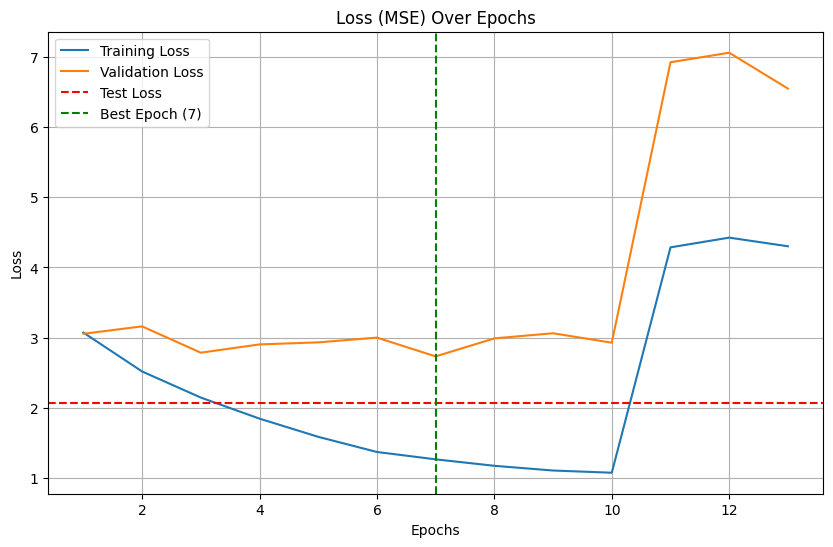

In [ ]:
# Define the best epoch
best_epoch = 7  # You can adjust this to the actual best epoch

# Plot Loss (MSE)
plt.figure(figsize=(10, 6))
plt.plot(range(1, last_epoch), loaded_train_losses, label='Training Loss')
plt.plot(range(1, last_epoch), loaded_val_losses, label='Validation Loss')
plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')
plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')  # Add a vertical line
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss (MSE) Over Epochs')
plt.legend()
plt.grid(True)

# Define the path to save the PDF file
save_path = '/content/drive/My Drive/M2BI_DRIVE/loss_plot.pdf'

# Save the plot to a PDF file
plt.savefig(save_path, format='pdf', bbox_inches='tight')

# Show the plot (optional)
plt.show()

RMSE

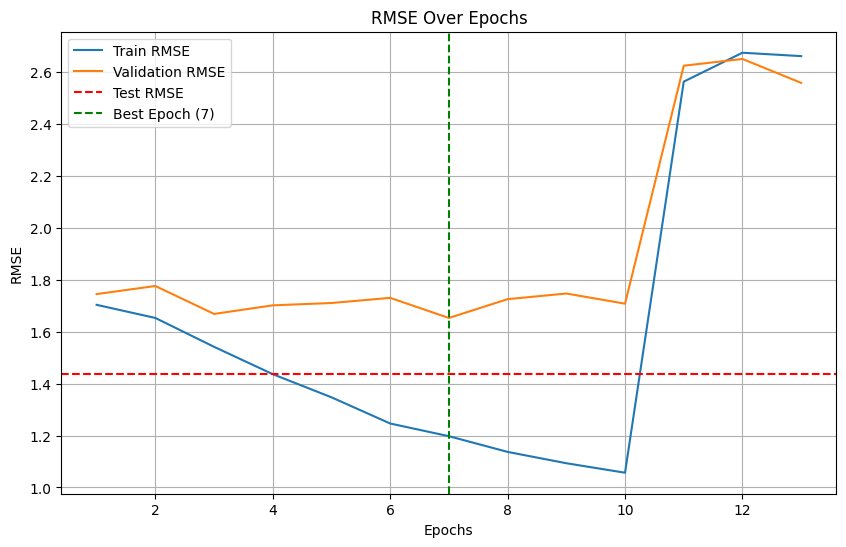

In [ ]:
# Plot RMSE
plt.figure(figsize=(10, 6))
plt.plot(range(1, last_epoch), loaded_train_rmses, label='Train RMSE')
plt.plot(range(1, last_epoch), loaded_val_rmses, label='Validation RMSE')
plt.axhline(y=test_rmse, color='r', linestyle='--', label='Test RMSE')
plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.title('RMSE Over Epochs')
# Define the path to save the PDF file
save_path = '/content/drive/My Drive/M2BI_DRIVE/RMSE_plot.pdf'

# Save the plot to a PDF file
plt.savefig(save_path, format='pdf', bbox_inches='tight')

# Show the plot (optional)
plt.show()

MAE

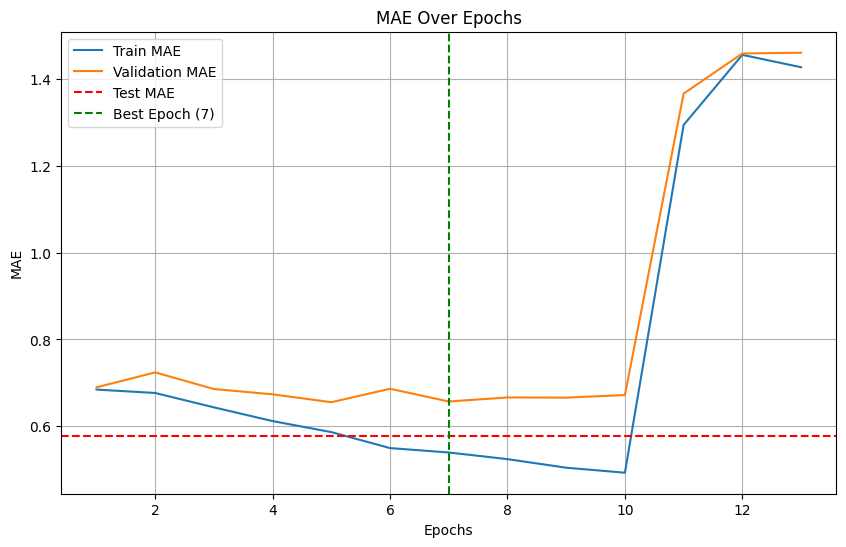

In [ ]:
# Plot MAE
plt.figure(figsize=(10, 6))
plt.plot(range(1, last_epoch), loaded_train_maes, label='Train MAE')
plt.plot(range(1, last_epoch), loaded_val_maes, label='Validation MAE')
plt.axhline(y=test_mae, color='r', linestyle='--', label='Test MAE')
plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.title('MAE Over Epochs')
# Define the path to save the PDF file
save_path = '/content/drive/My Drive/M2BI_DRIVE/MAE_plot.pdf'

# Save the plot to a PDF file
plt.savefig(save_path, format='pdf', bbox_inches='tight')

# Show the plot (optional)
plt.show()

Compare actual values to predicted values

In [ ]:
# Convert y_test to a single NumPy array
#y_test_array = np.array([np.array(arr) for arr in y_test])
y_test_array = np.empty(len(y_test), dtype=object)
for i in range(len(y_test)):
    y_test_array[i] = np.array(y_test[i])

# Create an empty list to store the predictions
predictions = []

# Iterate through the sequences in X_test and make predictions
for input_sequence in X_test:
    # Predict reactivity values for the current RNA sequence using the loaded model
    predicted_value = model.predict(np.array(input_sequence).reshape(1, -1, 4))
    # Append the predicted value to the list of predictions
    predictions.append(predicted_value)

# Extract DMS values
y_test_dms = [y_test[:, 0] for y_test in y_test_array]

# To separate for all predictions, you can use a loop or list comprehension
y_test_pred_dms = [y_pred[0][:, 0] for y_pred in predictions]

# Flatten the nested arrays
flattened_y_test_dms = np.concatenate(y_test_dms)
flattened_y_test_pred_dms = np.concatenate(y_test_pred_dms)

# Find non-NaN indices in flattened_y_test_dms
non_nan_indices_dms = ~np.isnan(flattened_y_test_dms)

# Extract non-NaN values from flattened_y_test_dms and flattened_y_test_pred_dms
y_test_dms_non_nan = flattened_y_test_dms[non_nan_indices_dms]
y_test_pred_dms_non_nan = flattened_y_test_pred_dms[non_nan_indices_dms]

# Calculate the prediction errors
errors_dms = y_test_dms_non_nan - y_test_pred_dms_non_nan

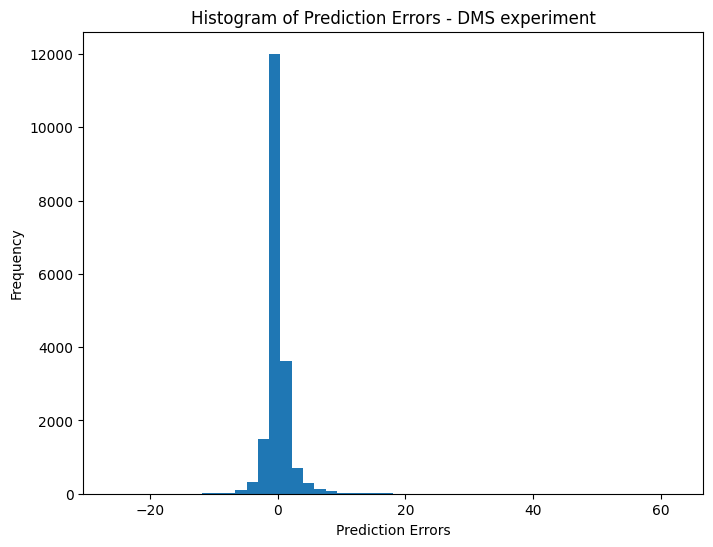

In [ ]:
# Create a histogram of prediction errors
plt.figure(figsize=(8, 6))
plt.hist(errors_dms, bins=50)
plt.xlabel('Prediction Errors')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors - DMS experiment')
# Define the path to save the PDF file
save_path = '/content/drive/My Drive/M2BI_DRIVE/Histogram_DMS.pdf'

# Save the plot to a PDF file
plt.savefig(save_path, format='pdf', bbox_inches='tight')

# Show the plot (optional)
plt.show()

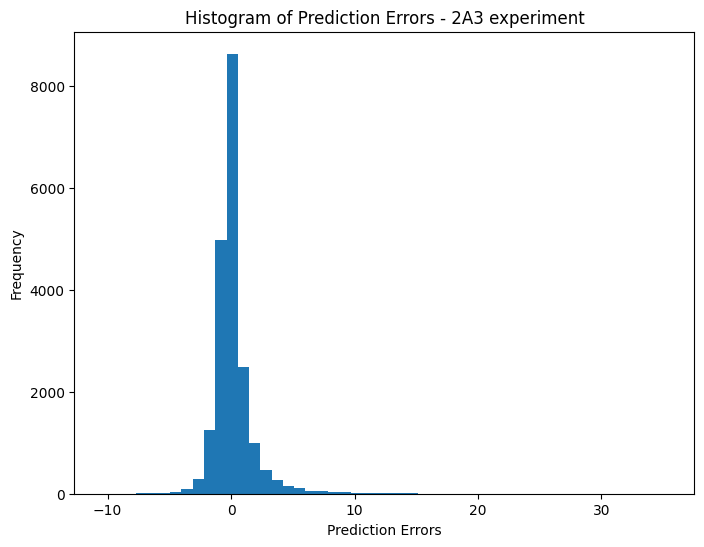

In [ ]:
# Calculate prediction errors
y_test_2a3 = [y_test[:, 1] for y_test in y_test_array]

# To separate for all predictions, you can use a loop or list comprehension
y_test_pred_2a3 = [y_pred[0][:, 1] for y_pred in predictions]

# Flatten the nested arrays
flattened_y_test_2a3 = np.concatenate(y_test_2a3)
flattened_y_test_pred_2a3 = np.concatenate(y_test_pred_2a3)

# Find non-NaN indices in flattened_y_test_2a3
non_nan_indices_2a3 = ~np.isnan(flattened_y_test_2a3)

# Extract non-NaN values from flattened_y_test_2a3 and flattened_y_test_pred_2a3
y_test_2a3_non_nan = flattened_y_test_2a3[non_nan_indices_2a3]
y_test_pred_2a3_non_nan = flattened_y_test_pred_2a3[non_nan_indices_2a3]

# Calculate the prediction errors
errors_2a3 = y_test_2a3_non_nan - y_test_pred_2a3_non_nan

# Create a histogram of prediction errors
plt.figure(figsize=(8, 6))
plt.hist(errors_2a3, bins=50)
plt.xlabel('Prediction Errors')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors - 2A3 experiment')
# Define the path to save the PDF file
save_path = '/content/drive/My Drive/M2BI_DRIVE/Histogram_2A3.pdf'

# Save the plot to a PDF file
plt.savefig(save_path, format='pdf', bbox_inches='tight')

# Show the plot (optional)
plt.show()

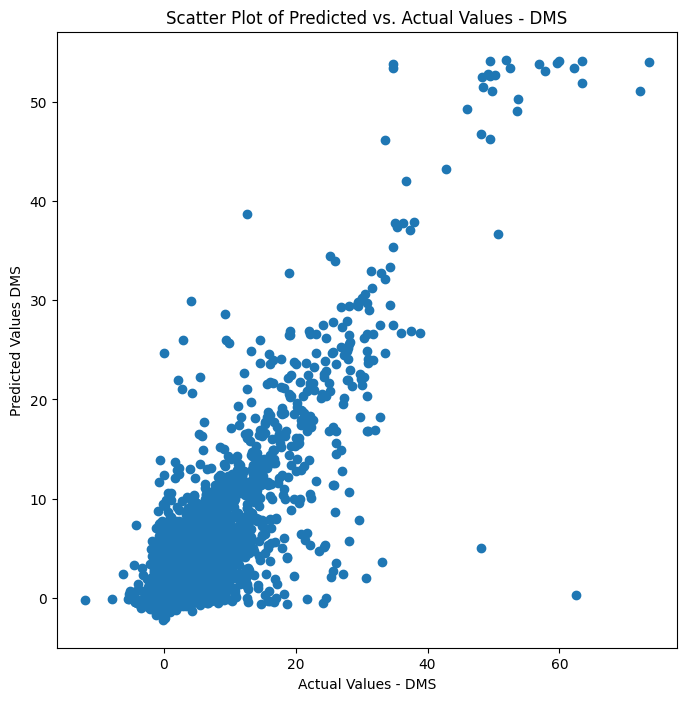

In [ ]:
# Create a scatter plot for non-NaN predicted vs. actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_dms_non_nan, y_test_pred_dms_non_nan)
plt.xlabel('Actual Values - DMS')
plt.ylabel('Predicted Values DMS')
plt.title('Scatter Plot of Predicted vs. Actual Values - DMS')

# Define the path to save the PDF file
save_path = '/content/drive/My Drive/M2BI_DRIVE/Scatter_Plot_DMS.pdf'

# Save the plot to a PDF file
plt.savefig(save_path, format='pdf', bbox_inches='tight')

# Show the plot (optional)
plt.show()

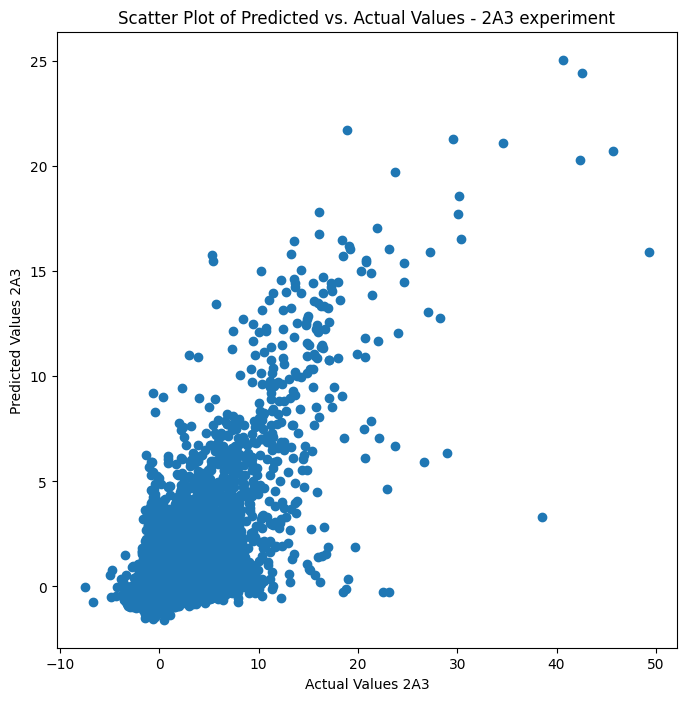

In [ ]:
# Create a scatter plot for non-NaN predicted vs. actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_2a3_non_nan, y_test_pred_2a3_non_nan)
plt.xlabel('Actual Values 2A3')
plt.ylabel('Predicted Values 2A3')
plt.title('Scatter Plot of Predicted vs. Actual Values - 2A3 experiment')

# Define the path to save the PDF file
save_path = '/content/drive/My Drive/M2BI_DRIVE/Scatter_Plot_2A3.pdf'

# Save the plot to a PDF file
plt.savefig(save_path, format='pdf', bbox_inches='tight')

# Show the plot (optional)
plt.show()

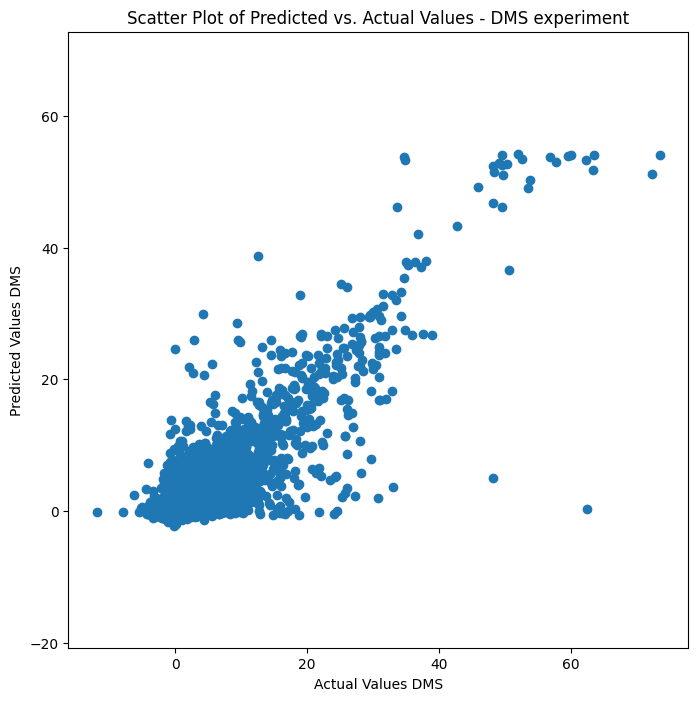

In [ ]:
# Create a scatter plot for non-NaN predicted vs. actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_dms_non_nan, y_test_pred_dms_non_nan)
plt.xlabel('Actual Values DMS')
plt.ylabel('Predicted Values DMS')
plt.title('Scatter Plot of Predicted vs. Actual Values - DMS experiment')

# Force equal aspect ratio on both axes
plt.axis('equal')

# Define the path to save the PDF file
save_path = '/content/drive/My Drive/M2BI_DRIVE/Scatter_Plot_DMS_with_equal.pdf'

# Save the plot to a PDF file
plt.savefig(save_path, format='pdf', bbox_inches='tight')

# Show the plot (optional)
plt.show()

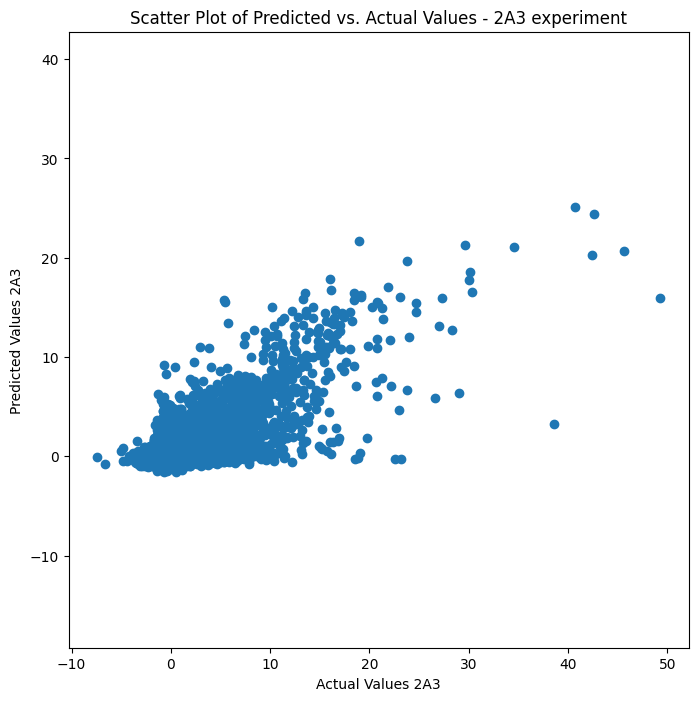

In [ ]:
# Create a scatter plot for non-NaN predicted vs. actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_2a3_non_nan, y_test_pred_2a3_non_nan)
plt.xlabel('Actual Values 2A3')
plt.ylabel('Predicted Values 2A3')
plt.title('Scatter Plot of Predicted vs. Actual Values - 2A3 experiment')

# Force equal aspect ratio on both axes
plt.axis('equal')

# Define the path to save the PDF file
save_path = '/content/drive/My Drive/M2BI_DRIVE/Scatter_Plot_2A3_with_equal.pdf'

# Save the plot to a PDF file
plt.savefig(save_path, format='pdf', bbox_inches='tight')

# Show the plot (optional)
plt.show()

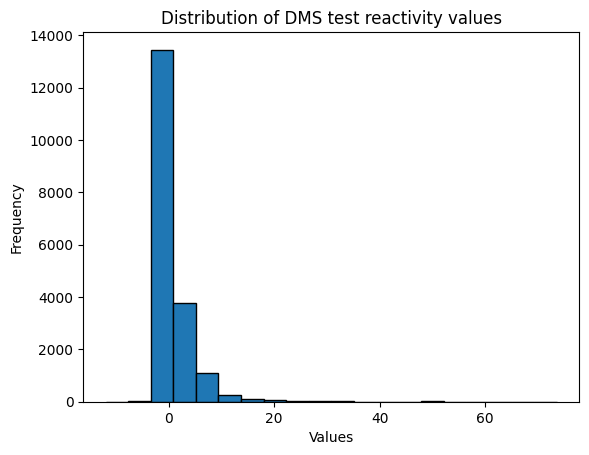

In [ ]:
# Distribution of DMS test reactivity values
plt.hist(y_test_dms_non_nan, bins=20, edgecolor='k')
plt.title("Distribution of DMS test reactivity values")
plt.xlabel("Values")
plt.ylabel("Frequency")
# Define the path to save the PDF file
save_path = '/content/drive/My Drive/M2BI_DRIVE/DMS_test_reactivity_values.pdf'

# Save the plot to a PDF file
plt.savefig(save_path, format='pdf', bbox_inches='tight')

# Show the plot (optional)
plt.show()

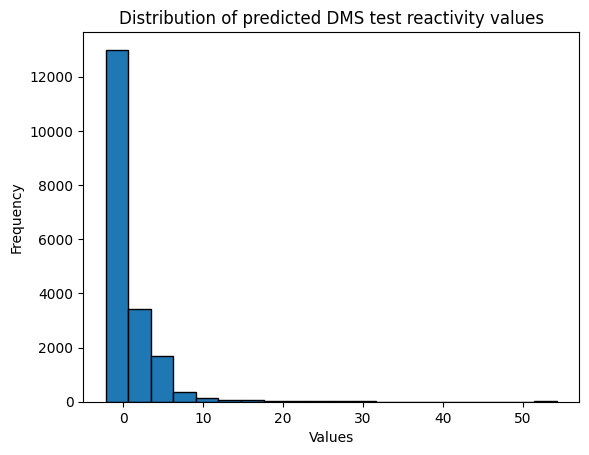

In [ ]:
# Distribution of predicted DMS test reactivity values
plt.hist(y_test_pred_dms_non_nan, bins=20, edgecolor='k')
plt.title("Distribution of predicted DMS test reactivity values")
plt.xlabel("Values")
plt.ylabel("Frequency")
# Define the path to save the PDF file
save_path = '/content/drive/My Drive/M2BI_DRIVE/predicted_DMS_test_reactivity_values.pdf'

# Save the plot to a PDF file
plt.savefig(save_path, format='pdf', bbox_inches='tight')

# Show the plot (optional)
plt.show()

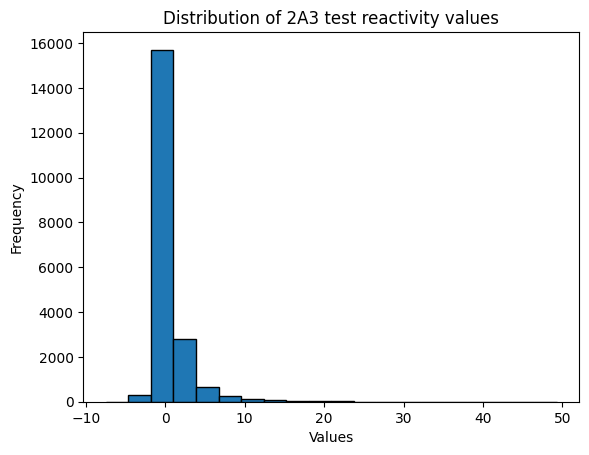

In [ ]:
# Distribution of predicted DMS test reactivity values
plt.hist(y_test_2a3_non_nan, bins=20, edgecolor='k')
plt.title("Distribution of 2A3 test reactivity values")
plt.xlabel("Values")
plt.ylabel("Frequency")
# Define the path to save the PDF file
save_path = '/content/drive/My Drive/M2BI_DRIVE/2A3_test_reactivity_values.pdf'

# Save the plot to a PDF file
plt.savefig(save_path, format='pdf', bbox_inches='tight')

# Show the plot (optional)
plt.show()

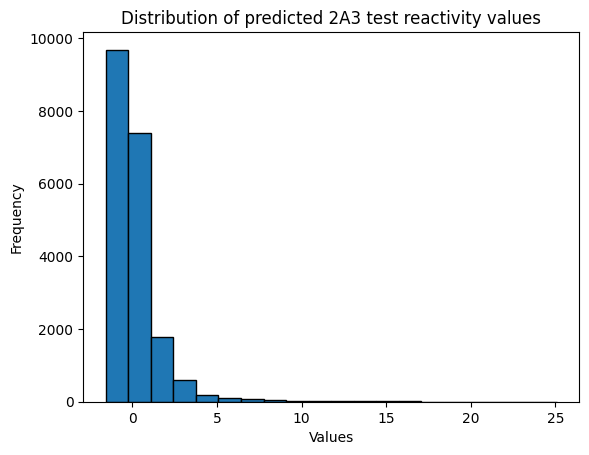

In [ ]:
# Distribution of predicted DMS test reactivity values
plt.hist(y_test_pred_2a3_non_nan, bins=20, edgecolor='k')
plt.title("Distribution of predicted 2A3 test reactivity values")
plt.xlabel("Values")
plt.ylabel("Frequency")
# Define the path to save the PDF file
save_path = '/content/drive/My Drive/M2BI_DRIVE/predicted_2A3_test_reactivity_values.pdf'

# Save the plot to a PDF file
plt.savefig(save_path, format='pdf', bbox_inches='tight')

# Show the plot (optional)
plt.show()

In [ ]:
!pip install auxiliary

In [ ]:
!pip install auxlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 1.1 MB/s eta 0:00:00


AttributeError: ignored

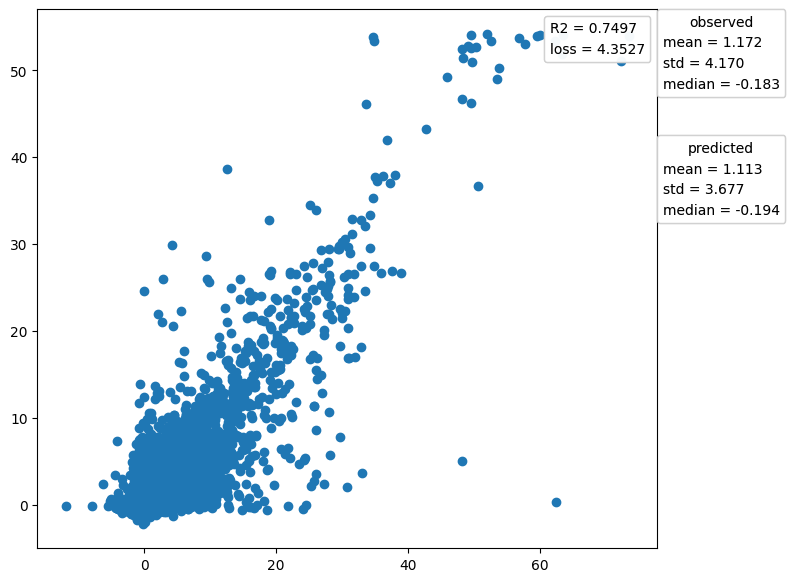

In [ ]:
"""This scripts contains plot functions."""

import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

from sklearn.metrics import r2_score

# Local modules
import auxiliary


def legend_patch(label, color="none"):
    """Returns the corresponding label with a Patch object for matplotlib legend purposes.

    label: str
        Character chain specifying the label
    color: str
        Corresponding color attribute for label

    Returns: tuple -> tuple(str, matplotlib.patches.Patch)
        Specified label with Patch

    """
    return label, mpatches.Patch(color=color, label=label)


def single_plot(yvalues, xvalues=None, scale = "linear", mode="plot",
                title="", metric="", xlabel="", ylabel="", alphas=(1,),
                xleft=None, xright=None, ytop=None, ybottom=None,
                loss=None, normalize=False, overwrite=True,
                save_to=None, filename="plot.png",
                showLoss=True, showY=True,
                pltlab="", **kwargs
):
    """Generate a specified figure from a set of values.

    yvalues: Iterator (numpy.ndarray)
        Values to plot, correspond to y axis

    xvalues: Iterator (numpy.ndarray)
        Values in x axis

    scale: str
        Chosen scale for observed and predicted values
        "linear", "log", ...

    mode: str
        Selected mode for plot taking values such as
        "plot" -> line plot
        "bar" -> barplot plot
        "hist" -> histogram plot
        "hist2d" -> histogram2d plot
        "scatter" -> scatter plot
        "violin" -> violin plot

    title, xlabel, ylabel: str
        Title, x-axis and y-axis labels to assign to
        the figure

    xleft, xright: float, optional
        lower and upper x limit

    ybottom, ytop: int, optional
        lower and upper y limit

    alphas: tuple(float), optional
        alpha values for the plot

    normalize: bool
        Normalize values so that it is bound to [0; 1]

    Returns: tuple (matplotlib.figure, matplotlib.axes.Axes)
        Figure and Axes for graphical purposes

    """
    # Plot mode selection
    plotting_mode = {
        "plot": lambda ax: ax.plot,
        'bar': lambda ax: ax.bar,
        "hist": lambda ax: ax.hist,
        "scatter": lambda ax: ax.scatter,
        "hist2d": lambda ax: ax.hist2d,
        "violin": lambda ax: ax.violinplot
    }
    # Check mode
    if mode not in plotting_mode.keys():
        raise Exception("Selected mode is invalid")

    # x-axis equals indices if not set
    if xvalues is None:
        xvalues = np.arange(yvalues.shape[0])

    alphas = (1,) if alphas is None else alphas
    alphas = (alphas, ) if isinstance(alphas, (int, float)) else tuple(alphas)
    alphas = alphas + (1,)

    # Optional arguments
    if mode.startswith("hist"):
        kwargs["bins"] = kwargs.get("bins", 100)  # necessary if mode == "hist"/"hist2d"
        kwargs["cmap"] = kwargs.get("cmLoadap", plt.cm.jet)
        kwargs["norm"] = kwargs.get("norm", mcolors.LogNorm())

    xticks = kwargs.get("xticks", None)
    yticks = kwargs.get("yticks", None)
    grid = kwargs.get("grid", False)

    # Conversion
    if not isinstance(yvalues, np.ndarray):
        yvalues = np.array(yvalues)

    if not isinstance(xvalues, np.ndarray):
        xvalues = np.array(xvalues)

    # Metrics
    if normalize:
        # Normalization needed before mean, std, median calculation
        yvalues = auxiliary.normalization_min_max(yvalues, 0, 1)


    # Observed and Predicted : Mean, std, median
    mean_yvalues = yvalues.mean()
    std_yvalues = yvalues.std()
    median_yvalues = np.median(yvalues)

    # Plot depending on mode
    fig, ax = plt.subplots(figsize=(8, 7))
    if (mode == "plot"):
        plotting_mode[mode](ax)(xvalues, yvalues, label=pltlab, alpha=alphas[0], **kwargs)
    elif (mode == "hist"):
        bins=kwargs["bins"]
        plotting_mode[mode](ax)(yvalues, bins=bins, label=pltlab, alpha=alphas[0])
    elif (mode == "bar"):
        plotting_mode[mode](ax)(xvalues, yvalues, label=pltlab, alpha=alphas[0], **kwargs)
    elif (mode == "violin"):
        v1 = plotting_mode[mode](ax)(yvalues, positions=[0], **kwargs)
        labels = []
        labels.append((mpatches.Patch(color=v1["bodies"][0].get_facecolor().flatten()), pltlab))
        main_legend = ax.legend(*zip(*labels), loc=2)
        ax.add_artist(main_legend)
    elif (mode == "scatter"):
        plotting_mode[mode](ax)(xvalues, yvalues, alpha=alphas[0], **kwargs)
    elif (mode == "hist2d"):
        plotting_mode[mode](ax)(xvalues, yvalues, **kwargs)

    #
    if True:
        # Main Legend
        handles, labels = ax.get_legend_handles_labels()
        if (handles != []) & (labels != []):
            main_legend = ax.legend(handles, labels, loc="upper left")
            ax.add_artist(main_legend)

        ## Loss
        if showLoss:
            handles_loss, labels_loss = [], []
            loss_label, loss_patch = legend_patch(f"loss = {loss:.4f}")
            handles_loss.append(loss_patch)
            labels_loss.append(loss_label)

            loss_legend = ax.legend(handles_loss, labels_loss, loc="upper right",
                                    handlelength=0, handletextpad=0)
        if showY:
            handles_y, labels_y = [], []
            mean_yvalues_label, mean_yvalues_patch = legend_patch(f"mean = {mean_yvalues:.3f}")
            std_yvalues_label, std_yvalues_patch = legend_patch(f"std = {std_yvalues:.3f}")
            median_yvalues_label, median_yvalues_patch = legend_patch(f"median = {median_yvalues:.3f}")

            handles_y.extend([mean_yvalues_patch, std_yvalues_patch, median_yvalues_patch])
            labels_y.extend([mean_yvalues_label, std_yvalues_label, median_yvalues_label])

            msm_observed_legend = fig.legend(handles_y, labels_y, title="observed",
                                            handlelength=0, handletextpad=0, borderaxespad=0,
                                            bbox_to_anchor=(1.06, 0.88))

            # Add legend
            ax.add_artist(msm_observed_legend)

        # Add legend
        ax.add_artist(loss_legend)

    # Scale selected by user
    ax.set_xscale(scale)
    ax.set_yscale(scale)
    # Option for specific mode
    if (mode == "scatter"):
        # Range to have xlim=ylim
        xy_lim = auxiliary.min_max(ax.get_xlim() + ax.get_ylim())
        ax.set_xlim(xy_lim)
        ax.set_ylim(xy_lim)

    # Set figure label, limit and legend
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)

    # Label
    ax.set_title(title + f" - scale={scale}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # Limit in x and y
    ax.set_xlim(left=xleft, right=xright)
    ax.set_ylim(top=ytop, bottom=ybottom)
    # Grid
    ax.grid(grid)

    if save_to is not None:
        if not auxiliary.isdir(save_to):
            raise Exception("Specified directory does not exists")

        root, _ = os.path.splitext(filename)
        root = root if root.isalnum() else f"plot_{mode}"
        # Save file to
        save_to = auxiliary.to_dirpath(save_to)
        filename = auxiliary.replace_extension(root, "png")
        filepath = save_to + filename if overwrite else \
                   auxiliary.filepath_with_suffix(save_to + filename)

        plt.savefig(filepath, bbox_inches = 'tight')

    return fig, ax


def plot(indices, observed, predicted, scale = "linear", mode="plot",
         title="", metric="", xlabel="", ylabel="", alphas=(1, 1),
         xleft=None, xright=None, ytop=None, ybottom=None,
         r2=None, loss=None, normalize=False,
         save_to=None, filename="plot.png", overwrite=True,
         showR2=True, showLoss=True, showY=True,
         lab_1="observed", lab_2="predicted",
         **kwargs
):
    """Generate a specified figure.

    indices: Iterator (numpy.ndarray)
        Observed and predicted indices to perform plots on
        values need to be in array observed/predicted indices range.

    observed: Iterator (numpy.ndarray)
        Observed values

    predicted: Iterator (numpy.ndarray)
        Predicted values

    scale: str
        Chosen scale for observed and predicted values
        "linear", "log", ...

    mode: str
        Selected mode for plot taking values such as
        "plot" -> line plot
        "bar" -> barplot plot
        "hist" -> histogram plot
        "hist2d" -> histogram2d plot
        "scatter" -> scatter plot
        "violin" -> violin plot

    title, xlabel, ylabel: str
        Title, x-axis and y-axis labels to assign to
        the figure

    xleft, xright: float, optional
        lower and upper x limit

    ybottom, ytop: int, optional
        lower and upper y limit

    alphas: tuple(float), optional
        alpha values for the plot

    normalize: bool
        Normalize values so that it is bound to [0; 1] values
        or [-1; 1] values if delta=True

    lab_1, lab_2: str, str
        Label associated with {observed} and {predicted} values

    Returns: tuple (matplotlib.figure, matplotlib.axes.Axes)
        Figure and Axes for graphical purposes

    """
    # Plot mode selection
    plotting_mode = {
        "plot": lambda ax: ax.plot,
        **dict.fromkeys(['bar', 'delta_bar'], lambda ax: ax.bar),
        "hist": lambda ax: ax.hist,
        "scatter": lambda ax: ax.scatter,
        "hist2d": lambda ax: ax.hist2d,
        "violin": lambda ax: ax.violinplot
    }
    # Check mode
    if mode not in plotting_mode.keys():
        raise Exception("Selected mode is invalid")

    alphas = (1,) if alphas is None else alphas
    alphas = (alphas, ) if isinstance(alphas, (int, float)) else tuple(alphas)
    alphas = alphas + (1,)
    delta = True if mode.startswith("delta") else False

    # Optional arguments
    if mode.startswith("hist"):
        kwargs["bins"] = kwargs.get("bins", 100)  # necessary if mode == "hist"/"hist2d"
        kwargs["cmap"] = kwargs.get("cmLoadap", plt.cm.jet)
        kwargs["norm"] = kwargs.get("norm", mcolors.LogNorm())

    xticks = kwargs.get("xticks", None)
    yticks = kwargs.get("yticks", None)
    grid = kwargs.get("grid", False)

    # Conversion
    if not isinstance(indices, np.ndarray):
        indices = np.array(indices)

    if not isinstance(observed, np.ndarray):
        observed = np.array(observed)

    if not isinstance(predicted, np.ndarray):
        predicted = np.array(predicted)

    # Metrics
    r2 = r2 if r2 else r2_score(observed, predicted)
    loss = loss if loss else ((observed - predicted) ** 2).mean()

    if normalize:
        # Normalization needed before mean, std, median calculation
        op_concat = np.concatenate((observed, predicted), axis=0)
        if not delta:
            op_concat = auxiliary.normalization_min_max(all, 0, 1)
            observed = op_concat[:observed.shape[0]]
            predicted = op_concat[observed.shape[0]:]

    # Observed and Predicted : Mean, std, median
    mean_observed, std_observed = observed.mean(), observed.std()
    mean_predicted, std_predicted = predicted.mean(), predicted.std()
    median_observed, median_predicted = np.median(observed), np.median(predicted)

    # Delta (Observed - Predicted)
    delta_values = observed - predicted
    delta_values = auxiliary.normalization_min_max(delta_values, -1, 1) if normalize else delta_values

    # Delta (Observed - Predicted) : Mean, std, median
    mean_delta, std_delta = delta_values.mean(), delta_values.std()
    median_delta = np.median(delta_values)

    # Plot depending on mode
    fig, ax = plt.subplots(figsize=(8, 7))
    label_observed, label_predicted = lab_1, lab_2
    if (mode == "plot"):
        plotting_mode[mode](ax)(indices, observed[indices], label=label_observed, alpha=alphas[0], **kwargs)
        plotting_mode[mode](ax)(indices, predicted[indices], label=label_predicted, alpha=alphas[1], **kwargs)
    elif (mode == "hist"):
        bins=kwargs["bins"]
        plotting_mode[mode](ax)(observed[indices], bins=bins, label=label_observed, alpha=alphas[0])
        plotting_mode[mode](ax)(predicted[indices], bins=bins, label=label_predicted, alpha=alphas[1])
    elif (mode == "bar"):
        plotting_mode[mode](ax)(indices, observed[indices], label=label_observed, alpha=alphas[0], **kwargs)
        plotting_mode[mode](ax)(indices, predicted[indices], label=label_predicted, alpha=alphas[1], **kwargs)
    elif (mode == "violin"):
        v1 = plotting_mode[mode](ax)(observed[indices], positions=[0], **kwargs)
        v2 = plotting_mode[mode](ax)(predicted[indices], positions=[0.5], **kwargs)
        labels = []
        labels.append((mpatches.Patch(color=v1["bodies"][0].get_facecolor().flatten()), label_observed))
        labels.append((mpatches.Patch(color=v2["bodies"][0].get_facecolor().flatten()), label_predicted))
        main_legend = ax.legend(*zip(*labels), loc=2)
        ax.add_artist(main_legend)
    elif (mode == "scatter"):
        plotting_mode[mode](ax)(observed[indices], predicted[indices], alpha=alphas[0], **kwargs)
    elif (mode == "hist2d"):
        plotting_mode[mode](ax)(observed[indices], predicted[indices], **kwargs)
    elif (mode == "delta_bar"):
        delta_values_idx = delta_values[indices]
        plotting_mode[mode](ax)(indices, delta_values_idx, alpha=alphas[0], **kwargs)

    # Main Legend
    handles, labels = ax.get_legend_handles_labels()
    if (handles != []) & (labels != []):
        main_legend = ax.legend(handles, labels, loc="upper left")
        ax.add_artist(main_legend)

    if showR2 and showLoss:
        # R2 & Loss Legend
        handles_r2loss, labels_r2loss = [], []
        if showR2:
            ## R2
            r2_label, r2_patch = legend_patch(f"R2 = {r2:.4f}")
            handles_r2loss.append(r2_patch)
            labels_r2loss.append(r2_label)
        if showLoss:
            ## Loss
            loss_label, loss_patch = legend_patch(f"loss = {loss:.4f}")
            handles_r2loss.append(loss_patch)
            labels_r2loss.append(loss_label)

            r2_loss_legend = ax.legend(handles_r2loss, labels_r2loss, loc="upper right",
                                    handlelength=0, handletextpad=0)

        # Add legend
        ax.add_artist(r2_loss_legend)

    # Mean, std, median Legend
    if delta:
        # Delta : (Observed - Predicted)
        handles_delta, labels_delta = [], []
        mean_delta_label, mean_delta_patch = legend_patch(f"mean = {mean_delta:.3f}")
        std_delta_label, std_delta_patch = legend_patch(f"std = {std_delta:.3f}")
        median_delta_label, median_delta_patch = legend_patch(f"median = {median_delta:.3f}")

        handles_delta.extend([mean_delta_patch, std_delta_patch, median_delta_patch])
        labels_delta.extend([mean_delta_label, std_delta_label, median_delta_label])

        msm_delta_legend = fig.legend(handles_delta, labels_delta, title=f"Delta{metric}",
                                        handlelength=0, handletextpad=0, borderaxespad=0,
                                        bbox_to_anchor=(1.11, 0.88))
        # Add legend
        ax.add_artist(msm_delta_legend)
    else:
        # Observed
        handles_obs, labels_obs = [], []
        mean_observed_label, mean_observed_patch = legend_patch(f"mean = {mean_observed:.3f}")
        std_observed_label, std_observed_patch = legend_patch(f"std = {std_observed:.3f}")
        median_observed_label, median_observed_patch = legend_patch(f"median = {median_observed:.3f}")

        handles_obs.extend([mean_observed_patch, std_observed_patch, median_observed_patch])
        labels_obs.extend([mean_observed_label, std_observed_label, median_observed_label])

        msm_observed_legend = fig.legend(handles_obs, labels_obs, title="observed",
                                            handlelength=0, handletextpad=0, borderaxespad=0,
                                            bbox_to_anchor=(1.06, 0.88))

        # Add legend
        ax.add_artist(msm_observed_legend)

        # Predicted
        handles_pred, labels_pred = [], []
        mean_predicted_label, mean_predicted_patch = legend_patch(f"mean = {mean_predicted:.3f}")
        std_predicted_label, std_predicted_patch = legend_patch(f"std = {std_predicted:.3f}")
        median_predicted_label, median_predicted_patch = legend_patch(f"median = {median_predicted:.3f}")

        handles_pred.extend([mean_predicted_patch, std_predicted_patch, median_predicted_patch])
        labels_pred.extend([mean_predicted_label, std_predicted_label, median_predicted_label])

        msm_predicted_legend = fig.legend(handles_pred, labels_pred, title="predicted",
                                            handlelength=0, handletextpad=0, borderaxespad=0,
                                            bbox_to_anchor=(1.06, 0.7))

        # Add legend
        ax.add_artist(msm_predicted_legend)

    # Scale selected by user
    ax.set_xscale(scale)
    ax.set_yscale(scale)
    # Option for specific mode
    if (mode == "scatter"):
        title += f" - scale={scale}"
        # Range to have xlim=ylim
        xy_lim = auxiliary.min_max(ax.get_xlim() + ax.get_ylim())
        ax.set_xlim(xy_lim)
        ax.set_ylim(xy_lim)
    elif (mode == "delta_bar"):
        # Horizontal separation line
        ax.axhline(y=0, color='orange', linestyle = '--')
        # Range to have ylim(a, b) with a=max(absolute(y)) and a=b
        highest_value = max(np.abs(ax.get_ylim()))
        ax.set_ylim((-highest_value, highest_value))

    # Set figure label, limit and legend
    if xticks is not None:
        ax.set_xticks(xticks)
    if yticks is not None:
        ax.set_yticks(yticks)

    # Label
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # Limit in x and y
    ax.set_xlim(left=xleft, right=xright)
    ax.set_ylim(top=ytop, bottom=ybottom)
    # Grid
    ax.grid(grid)

    if save_to is not None:
        if not auxiliary.isdir(save_to):
            raise Exception("Specified directory does not exists")

        root, _ = os.path.splitext(filename)
        root = root if root.isalnum() else f"plot_{mode}"
        # Save file to
        save_to = auxiliary.to_dirpath(save_to)
        filename = auxiliary.replace_extension(root, "png")
        filepath = save_to + filename if overwrite else \
                   auxiliary.filepath_with_suffix(save_to + filename)

        plt.savefig(filepath, bbox_inches = 'tight')

    return fig, ax


if __name__ == "__main__":
    indices = indices
    obs = y_test_dms_non_nan
    pred = y_test_pred_dms_non_nan
    plot(indices, obs, pred, mode="scatter", save_to="/content/drive/My Drive/M2BI_DRIVE/sample_submission_folder/")

In [ ]:
errors_dms = y_test_dms_non_nan - y_test_pred_dms_non_nan

In [ ]:
print(y_test_pred_dms_non_nan)

[1.7506773 2.0135343 3.395775  ... 2.8043215 3.341182  5.8357444]


In [ ]:
indices = np.arange(len(y_test_pred_dms_non_nan))

print(indices)

[    0     1     2 ... 18906 18907 18908]


# **Save sample_submission file**

Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the model

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model

# Define custom loss which is a custom object
def custom_loss(y_true, y_pred, padded_value=0.0):
    nan_mask = tf.math.is_nan(y_true)
    padded_mask = tf.math.equal(y_true, padded_value)

    # Create a composite mask that identifies both NaN and padded values
    composite_mask = tf.math.logical_or(nan_mask, padded_mask)

    # Replace NaN and padded values with 0.0
    modified_true = tf.where(composite_mask, 0.0, y_true)

    # Calculate the mean squared difference (MSE)
    loss = tf.reduce_mean(tf.square(modified_true - y_pred))

    return loss

# Define a dictionary of custom objects to be used during model loading
custom_objects = {'custom_loss': custom_loss}

# Load the model from the file, providing the custom_objects dictionary
model = load_model('/content/drive/My Drive/M2BI_DRIVE/trained_model_9_val_loss_6.319265365600586_.h5', custom_objects=custom_objects)

Load test_sequences data

In [ ]:
import pandas as pd
import numpy as np
# Define the path of the CSV file
csv_path = '/content/drive/My Drive/M2BI_DRIVE/test_sequences.csv'

# Load the CSV file as a Dask DataFrame
test_sequences = pd.read_csv(csv_path)

In [ ]:
test_sequences = test_sequences.loc[:42,:]

Generate and save sample_submission.csv

In [ ]:
# Initialize empty lists to store the results
ids = []
reactivity_DMS_MaP_values = []
reactivity_2A3_MaP_values = []

# Define a mapping for nucleotides
nucleotide_mapping = {'A': (0, 0, 1, 0), 'C': (0, 0, 0, 1), 'G': (0, 1, 0, 0), 'U': (1, 0, 0, 0)}

# Initialize id counter
current_id = 0

# Define normalization parameters
dms_median = 0.12
dms_mad = 0.129
a3_median = 0.209
a3_mad = 0.209
robust_constant = 1.482602218505602

# Calculate the scaling factors for reverse normalization
dms_scaling_factor = robust_constant * dms_mad
a3_scaling_factor = robust_constant * a3_mad

# Iterate through each RNA sequence
for idx, sequence in enumerate(test_sequences['sequence']):
    # Initialize empty lists to store sequence-specific results
    sequence_ids = []
    sequence_reactivity_DMS_MaP = []
    sequence_reactivity_2A3_MaP = []

    # Convert the entire RNA sequence to the specified one-hot encoding format
    input_sequence = [nucleotide_mapping.get(nucleotide, (0, 0, 0, 0)) for nucleotide in sequence]

    # Predict reactivity values for the entire RNA sequence using the loaded model
    predicted_values = model.predict(np.array(input_sequence).reshape(1, -1, 4))

    # Iterate through each nucleotide in the sequence and extract the predictions
    for i, nucleotide in enumerate(sequence):
        sequence_ids.append(current_id)
        current_id += 1  # Increment the id

        # Reverse robust z-score normalization for reactivity_DMS_MaP
        reactivity_DMS_MaP = (predicted_values[0, i, 0] * dms_scaling_factor) + dms_median

        # Reverse robust z-score normalization for reactivity_2A3_MaP
        reactivity_2A3_MaP = (predicted_values[0, i, 1] * a3_scaling_factor) + a3_median

        sequence_reactivity_DMS_MaP.append(reactivity_DMS_MaP)
        sequence_reactivity_2A3_MaP.append(reactivity_2A3_MaP)

    # Extend the main lists with sequence-specific results
    ids.extend(sequence_ids)
    reactivity_DMS_MaP_values.extend(sequence_reactivity_DMS_MaP)
    reactivity_2A3_MaP_values.extend(sequence_reactivity_2A3_MaP)

# Create the "sample_submission" DataFrame
sample_submission = pd.DataFrame({
    'id': ids,
    'reactivity_DMS_MaP': reactivity_DMS_MaP_values,
    'reactivity_2A3_MaP': reactivity_2A3_MaP_values
})

# Save the sample_submission DataFrame to a CSV file
sample_submission.to_csv('/content/drive/My Drive/M2BI_DRIVE/sample_submission.csv', index=False)

qsdfqsdfqsdfqsdfqsdfqsdfqsdf

In [ ]:
total_rows = len(test_sequences)
rows_per_file = total_rows // 20

smaller_dataframes = [test_sequences.iloc[i:i + rows_per_file] for i in range(0, total_rows, rows_per_file)]

for i, smaller_df in enumerate(smaller_dataframes):
    smaller_df.to_csv(f"/content/drive/My Drive/M2BI_DRIVE/sample_submission_folder/smaller_file_{i+1}.csv", index=False)

In [ ]:
import pandas as pd
import numpy as np

# Initialize empty lists to store the results
ids = []
reactivity_DMS_MaP_values = []
reactivity_2A3_MaP_values = []

# Define a mapping for nucleotides
nucleotide_mapping = {'A': (0, 0, 1, 0), 'C': (0, 0, 0, 1), 'G': (0, 1, 0, 0), 'U': (1, 0, 0, 0)}

# Define normalization parameters
dms_median = 0.12
dms_mad = 0.129
a3_median = 0.209
a3_mad = 0.209
robust_constant = 1.482602218505602

# Iterate through each smaller CSV file
for i in range(1, 21):  # Assuming you have 20 smaller files
    csv_path = f"/content/drive/My Drive/M2BI_DRIVE/sample_submission_folder/smaller_file_{i}.csv"
    test_sequences = pd.read_csv(csv_path)

    # Initialize id counter
    current_id = 0

    # Calculate the scaling factors for reverse normalization
    dms_scaling_factor = robust_constant * dms_mad
    a3_scaling_factor = robust_constant * a3_mad

    # Initialize empty lists to store sequence-specific results
    sequence_ids = []
    sequence_reactivity_DMS_MaP = []
    sequence_reactivity_2A3_MaP = []

    # Iterate through each RNA sequence in the smaller file
    for idx, sequence in enumerate(test_sequences['sequence']):
        # Convert the entire RNA sequence to the specified one-hot encoding format
        input_sequence = [nucleotide_mapping.get(nucleotide, (0, 0, 0, 0)) for nucleotide in sequence]

        # Predict reactivity values for the entire RNA sequence using the loaded model
        predicted_values = model.predict(np.array(input_sequence).reshape(1, -1, 4))

        # Iterate through each nucleotide in the sequence and extract the predictions
        for i, nucleotide in enumerate(sequence):
            sequence_ids.append(current_id)
            current_id += 1  # Increment the id

            # Reverse robust z-score normalization for reactivity_DMS_MaP
            reactivity_DMS_MaP = (predicted_values[0, i, 0] * dms_scaling_factor) + dms_median

            # Reverse robust z-score normalization for reactivity_2A3_MaP
            reactivity_2A3_MaP = (predicted_values[0, i, 1] * a3_scaling_factor) + a3_median

            sequence_reactivity_DMS_MaP.append(reactivity_DMS_MaP)
            sequence_reactivity_2A3_MaP.append(reactivity_2A3_MaP)

    # Extend the main lists with sequence-specific results
    ids.extend(sequence_ids)
    reactivity_DMS_MaP_values.extend(sequence_reactivity_DMS_MaP)
    reactivity_2A3_MaP_values.extend(sequence_reactivity_2A3_MaP)

    # Create the "sample_submission" DataFrame for this smaller file
    sample_submission = pd.DataFrame({
        'id': ids,
        'reactivity_DMS_MaP': reactivity_DMS_MaP_values,
        'reactivity_2A3_MaP': reactivity_2A3_MaP_values
    })

    # Save the sample_submission DataFrame to a new CSV file for this iteration
    sample_submission.to_csv(f'/content/drive/My Drive/M2BI_DRIVE/sample_submission_folder/sample_submission_{i}.csv', index=False)

In [ ]:
print(test_sequences)

   id_min  id_max   sequence_id  \
0       0     176  eee73c1836bc   
1     177     353  d2a929af7a97   

                                            sequence  future  
0  GGGAACGACUCGAGUAGAGUCGAAAAUUUCCUUCCAAAUCCUGAGG...       0  
1  GGGAACGACUCGAGUAGAGUCGAAAAUGUAAUCAGAUUGCUUCUCC...       0  


In [ ]:
import pandas as pd

# Initialize an empty DataFrame to store the combined results
combined_submission = pd.DataFrame(columns=['id', 'reactivity_DMS_MaP', 'reactivity_2A3_MaP'])

# Iterate through the sample submission files
for i in range(1, 21):  # Assuming you have 20 sample submission files
    file_path = f'/content/drive/My Drive/M2BI_DRIVE/sample_submission_folder/sample_submission_{i}.csv'
    submission_df = pd.read_csv(file_path)

    # Concatenate the current submission DataFrame to the combined DataFrame
    combined_submission = pd.concat([combined_submission, submission_df], ignore_index=True)

# Replace the "id" column with row indices starting from 0
combined_submission['id'] = range(len(combined_submission))

# Save the combined submission DataFrame to a single CSV file
combined_submission.to_csv('/content/drive/My Drive/M2BI_DRIVE/sample_submission_folder/sample_submission.csv', index=False)

Divide CSV into 20 files. (à chercher dans chatgpt)